Total trainable parameters: 6,426,907
Total trainable parameters: 573,443


100%|██████████| 249/249 [00:08<00:00, 28.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59051526..2.5918322].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59399486..2.582447].


tensor([ 0.0848,  0.0267,  0.1008,  0.0464,  0.0807,  0.0895, -0.0043,  0.1490,
         0.0765,  0.0164], device='cuda:0')
tensor([1.0724, 0.9658, 1.3446, 1.1393, 1.2597, 1.1420, 1.1172, 1.8485, 1.6109,
        1.1002], device='cuda:0')
X_storage.shape: torch.Size([250, 3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58417195..2.571681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59377337..2.5582495].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56686264..2.543786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5691485..2.574773].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61640495..2.6343312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6657682..2.6488197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66884

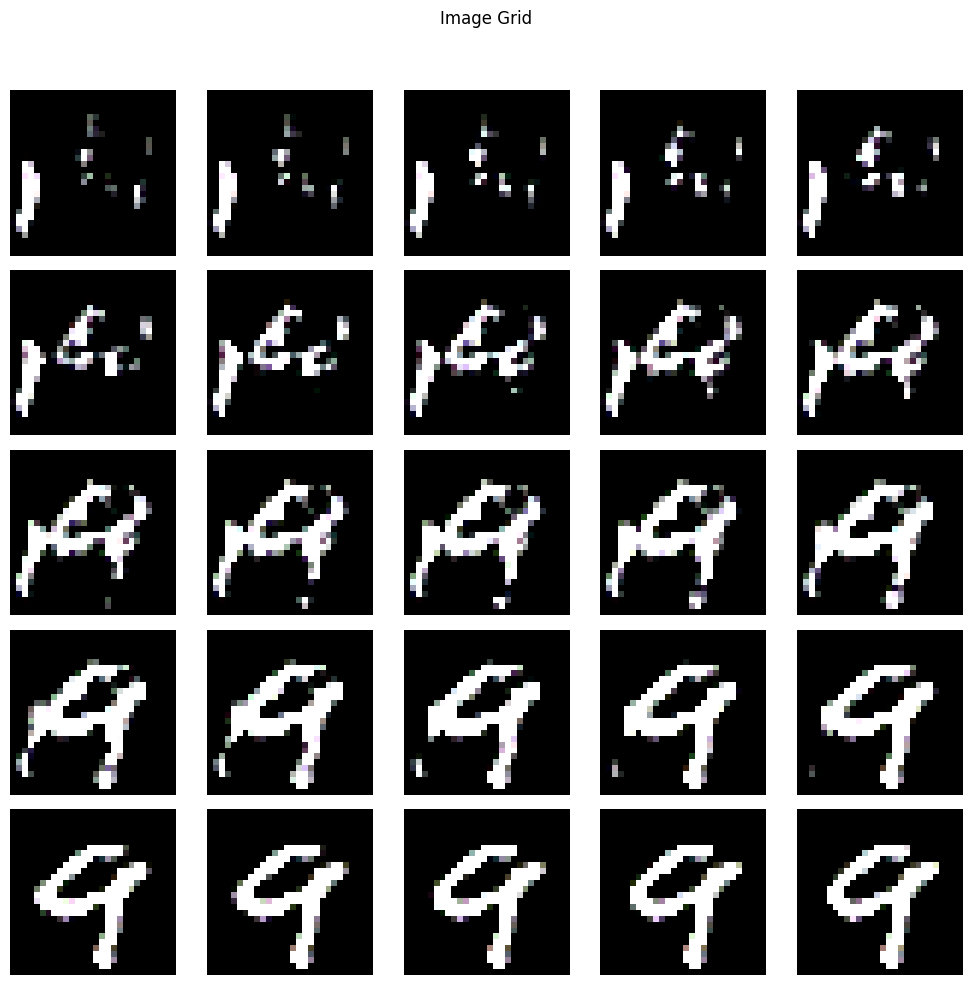

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5357073..3.0966656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5402043..3.0392346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60543704..3.1288288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6096009..3.1842473].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6451053..2.9572887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5594063..3.0474262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56382

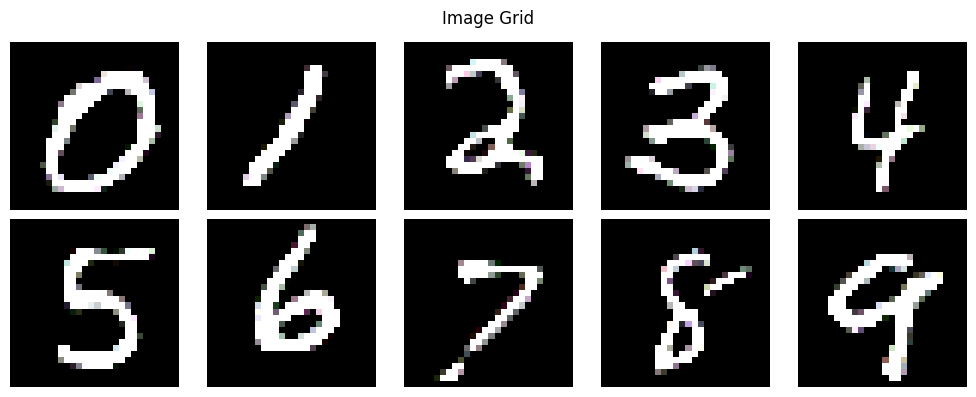

In [6]:
import torch 
from utils import generate_alpha_bar, plot_image_grid, generate_alpha
from models import count_parameters
import math 
from tqdm import tqdm

mym = torch.load("model_collection/guided_predictor3.pth", weights_only=False)
count_parameters(mym)
mym.eval()

dec = torch.load("model_collection/deczmuv.pth", weights_only=False)
count_parameters(dec)
dec.eval()

T = 250 
beta_0 = 0.001
beta_T = 0.05
a_bar = generate_alpha_bar(beta_0, beta_T, T)
alpha = generate_alpha(beta_0, beta_T, T)

batch_size = 10
z_t = torch.randn(batch_size, 3, 14, 14).cuda()
storage = torch.zeros((T, 3, 14, 14))

guided = torch.ones(batch_size).cuda()
# label = 3*torch.ones(batch_size).cuda().long()
label = torch.tensor(range(10)).cuda()

guidance_scale = 9

with torch.no_grad():
    for t in tqdm(range(T-1,0,-1)): 
        Z = torch.randn_like(z_t)
        sigma_t = 0.5 * (1 - alpha[t]) ** 0.5 
        if(t == 0): sigma_t = 0
        
        time = t * torch.ones(batch_size).cuda()


        z_in = torch.concat([z_t, z_t])
        time_in = torch.concat([time, time])
        label_in = torch.concat([label, label])
        guided_in = torch.concat([guided, 0*guided])

        noise = mym(z_in, time_in, label_in, guided_in)
        noise_guided = noise[:batch_size]
        noise_unguided = noise[batch_size:]
        noise = noise_unguided + guidance_scale * (noise_guided - noise_unguided)

        # PREDICT NEXT TIME STEP 
        z0_pred = (z_t - math.sqrt(1-a_bar[t]) * noise) / math.sqrt(a_bar[t])
        z_t = math.sqrt(a_bar[t-1]) * z0_pred + math.sqrt(1-a_bar[t-1]) * noise

        # z_t = (1/math.sqrt(alpha[t]))*(z_t - ((1-alpha[t])/(math.sqrt(1-a_bar[t]))) * noise) + sigma_t * Z
        storage[T-t-1] = z_t[-1].cpu()

print(z_t.mean(dim=(1,2,3)))
print(z_t.std(dim=(1,2,3)))


X_storage = dec(storage.cuda())
print("X_storage.shape:", X_storage.shape)

plot_image_grid(X_storage[::10])

X_out = dec(z_t)
plot_image_grid(X_out)



In [40]:
import torch
import cv2
import numpy as np

def save_tensor_to_mp4(tensor, output_path, fps=30, upscale_factor=8, normalize_method='minmax'):
    """
    Save a PyTorch tensor of shape (N, 3, 28, 28) as an MP4 video.
    Handles normally distributed values by normalizing them to [0, 255].
    
    Args:
        tensor (torch.Tensor): Tensor of shape (N, 3, 28, 28) containing N RGB frames
        output_path (str): Path where the MP4 file will be saved
        fps (int): Frames per second for the output video
        upscale_factor (int): Factor by which to upscale the frames for better visibility
        normalize_method (str): Method to normalize tensor values. Options:
            - 'minmax': Scale to [0, 255] based on min/max values
            - 'standard': Scale using mean and std (good for normally distributed data)
            - 'percentile': Scale using 1st and 99th percentiles to handle outliers
            - 'none': No normalization (assumes values are already in [0, 255])
    
    Returns:
        bool: True if successful, False otherwise
    """
    # Check if tensor has the expected shape
    if len(tensor.shape) != 4 or tensor.shape[1] != 3:
        raise ValueError(f"Expected tensor of shape (N, 3, H, W), got {tensor.shape}")
    
    # Make a copy to avoid modifying the original tensor
    tensor_proc = tensor.clone().detach()
    
    # Normalize the tensor values to [0, 255] range
    if normalize_method == 'minmax':
        # Simple min-max normalization
        min_val = tensor_proc.min()
        max_val = tensor_proc.max()
        if min_val != max_val:  # Avoid division by zero
            tensor_proc = (tensor_proc - min_val) * 255 / (max_val - min_val)
        else:
            tensor_proc = torch.zeros_like(tensor_proc)
    
    elif normalize_method == 'standard':
        # Normalize using mean and standard deviation (good for normally distributed values)
        # Scale to roughly 0-255 with most values in 0-200 range and clipping outliers
        mean = tensor_proc.mean()
        std = tensor_proc.std()
        # Center around mean and scale by std deviation
        # Values within 3 std deviations will be in approximately 0-255 range
        tensor_proc = (tensor_proc - mean) / (std + 1e-10) * 42 + 128
        tensor_proc = torch.clamp(tensor_proc, 0, 255)
    
    elif normalize_method == 'percentile':
        # Handle outliers by using percentiles instead of min/max
        tensor_flat = tensor_proc.reshape(tensor_proc.shape[0], -1)
        # Calculate per-frame percentiles
        for i in range(tensor_flat.shape[0]):
            values, _ = torch.sort(tensor_flat[i])
            n = values.shape[0]
            p1_idx, p99_idx = int(0.01 * n), int(0.99 * n)
            p1, p99 = values[p1_idx], values[p99_idx]
            # Scale to 0-255 based on these percentiles
            tensor_proc[i] = torch.clamp((tensor_proc[i] - p1) * 255 / (p99 - p1 + 1e-10), 0, 255)
    
    elif normalize_method == 'none':
        # Assume values are already in [0, 255] range
        tensor_proc = torch.clamp(tensor_proc, 0, 255)
    
    else:
        raise ValueError(f"Unknown normalization method: {normalize_method}")
    
    # Convert to uint8
    frames = tensor_proc.to(torch.uint8).cpu().numpy()
    
    # Get dimensions
    n_frames, n_channels, height, width = frames.shape
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1' for MP4
    
    # Upscale dimensions for better visibility
    output_width = width * upscale_factor
    output_height = height * upscale_factor
    
    out = cv2.VideoWriter(output_path, fourcc, fps, (output_width, output_height))
    
    # Write frames to video
    for i in range(n_frames):
        # Convert from (C, H, W) to (H, W, C) format and reorder from RGB to BGR
        frame = frames[i].transpose(1, 2, 0)[..., ::-1]
        
        # Upscale frame
        frame = cv2.resize(frame, (output_width, output_height), interpolation=cv2.INTER_NEAREST)
        
        # Write to video
        out.write(frame)
    
    # Release the video writer
    out.release()
    
    print(f"Video saved to {output_path}")
    return True


Video saved to output_percentile.mov


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57428354..2.976943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5652461..2.9245317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52002025..2.771805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54599386..2.4219904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53975195..2.3912926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.517721..2.5171163].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54593

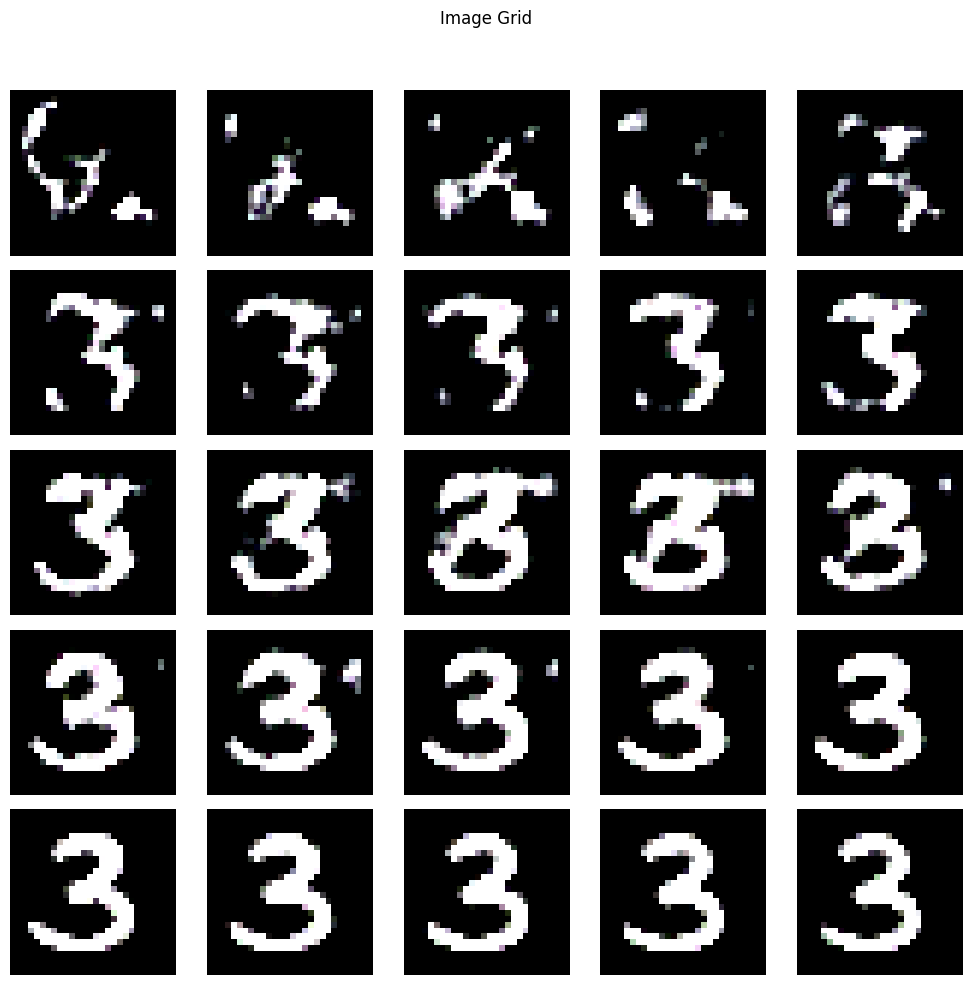

: 

In [ ]:
save_tensor_to_mp4(X_storage, "output_percentile.mov", fps=50,normalize_method='percentile')

plot_image_grid(X_storage[::10])